# User Based Similarity

In [1]:
import vaex
import numpy as np
import pandas as pd

In [2]:
%%time

ratings = vaex.read_csv('data/movie_ratings.csv', convert=True, chunk_size=1_000_000)
ratings = ratings[ratings['rating'] >= 3.5].extract()
ratings.drop(columns=['rating'], inplace=True)

movies = ratings.groupby(by='id', agg={'num_likes': vaex.agg.nunique('user')})

print(ratings.shape)
print(movies.shape)

(15726145, 2)
(3931, 2)
CPU times: user 7.71 s, sys: 1.93 s, total: 9.64 s
Wall time: 2.83 s


In [3]:
NUM_EVENTS = 500
np.random.seed(0)

prob = movies['num_likes'].values / movies['num_likes'].sum()
ids = np.random.choice(movies['id'].values, size=NUM_EVENTS, p=prob)

ratings = ratings[ratings['id'].isin(ids)].extract()

print(ratings.shape)

(4954040, 2)


In [4]:
%%time

likes_left = ratings.copy()
likes_left.rename('id', 'id_left')

likes_right = ratings.copy()
likes_right.rename('id', 'id_right')

movie_sim = likes_left.join(likes_right, on='user', allow_duplication=True)

print(movie_sim.shape)

(278513590, 3)
CPU times: user 8.98 s, sys: 17.5 s, total: 26.4 s
Wall time: 13.5 s


In [5]:
%%time

movie_sim = movie_sim[movie_sim['id_left'] != movie_sim['id_right']].extract()
print(movie_sim.shape)

(273559550, 3)
CPU times: user 7.42 s, sys: 2.33 s, total: 9.75 s
Wall time: 4.12 s


In [6]:
%%time

movie_sim = movie_sim.join(movies, left_on='id_left', right_on='id')
movie_sim.drop(columns=['id'], inplace=True)
movie_sim.rename('num_likes', 'num_likes_left')

movie_sim = movie_sim.join(movies, left_on='id_right', right_on='id')
movie_sim.drop(columns=['id'], inplace=True)
movie_sim.rename('num_likes', 'num_likes_right')

movie_sim.head()

CPU times: user 10.7 s, sys: 216 ms, total: 10.9 s
Wall time: 917 ms


#,user,id_left,id_right,num_likes_left,num_likes_right
0,4,2,1,12344,50814
1,4,10,1,16775,50814
2,4,11,1,12143,50814
3,4,16,1,15215,50814
4,4,25,1,15545,50814
5,4,34,1,21916,50814
6,4,36,1,17473,50814
7,4,50,1,55201,50814
8,4,110,1,53545,50814
9,4,141,1,14229,50814


In [7]:
%%time

agg_funs = {'num_likes_both':vaex.agg.count('user'), 'num_likes_left':vaex.agg.max('num_likes_left'), 'num_likes_right':vaex.agg.max('num_likes_right')}
movie_sim = movie_sim.groupby(by=['id_left','id_right'], agg=agg_funs)
movie_sim['similarity'] = movie_sim['num_likes_both'] / np.exp(0.5*np.log(movie_sim['num_likes_left']) + 0.5*np.log(movie_sim['num_likes_right']))
movie_sim.head()

CPU times: user 47.7 s, sys: 0 ns, total: 47.7 s
Wall time: 2.34 s


#,id_left,id_right,num_likes_both,num_likes_left,num_likes_right,similarity
0,1270,5952,19255,44259,47272,0.42096
1,1270,6333,8951,44259,15313,0.343828
2,1270,6373,4528,44259,8129,0.238719
3,1270,6377,14349,44259,29304,0.398435
4,1270,6565,2405,44259,4145,0.177563
5,1270,6979,3371,44259,4369,0.242419
6,1270,7090,4100,44259,7355,0.227244
7,1270,8360,7714,44259,14017,0.309707
8,1270,8874,8396,44259,16129,0.314245
9,1270,38038,2836,44259,4592,0.198932


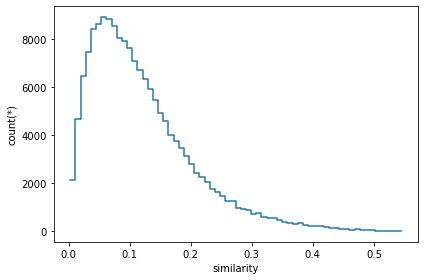

In [8]:
movie_sim.plot1d(movie_sim.similarity, limits='99.9%')

In [9]:
movie_sim_pd = movie_sim.to_pandas_df()
movie_sim_pd.sort_values(['id_left','similarity'], ascending=[True,False], inplace=True)
movie_sim_pd = movie_sim_pd.groupby('id_left').head(30)

print(movie_sim.shape)
print(movie_sim_pd.shape)

movie_sim_pd.to_csv('output/movie_similarity.csv', index=False)

(170142, 6)
(12390, 6)


In [10]:
movies_info = pd.read_csv('data/movie_info.csv', usecols=['id','title'])

high_sim = pd.merge(movie_sim_pd, movies_info, left_on='id_left', right_on='id')
high_sim.drop(columns=['id'], inplace=True)
high_sim.rename(columns={'title':'title_left'}, inplace=True)

high_sim = pd.merge(high_sim, movies_info, left_on='id_right', right_on='id')
high_sim.drop(columns=['id'], inplace=True)
high_sim.rename(columns={'title':'title_right'}, inplace=True)

display(high_sim[['id_left','title_left','title_right','similarity']].sort_values('similarity', ascending=False)
                                                                     .head(30))

,id_left,title_left,title_right,similarity
6786,4993,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Two Towers,0.832620
6203,5952,The Lord of the Rings: The Two Towers,The Lord of the Rings: The Fellowship of the Ring,0.832620
4712,1196,The Empire Strikes Back,Star Wars,0.754107
2249,260,Star Wars,The Empire Strikes Back,0.754107
10625,69844,Harry Potter and the Half-Blood Prince,Harry Potter and the Deathly Hallows: Part 1,0.734474
10600,81834,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Half-Blood Prince,0.734474
3938,1200,Aliens,Alien,0.717800
4325,1214,Alien,Aliens,0.717800
959,5816,Harry Potter and the Chamber of Secrets,Harry Potter and the Philosopher's Stone,0.703306
1426,4896,Harry Potter and the Philosopher's Stone,Harry Potter and the Chamber of Secrets,0.703306


In [11]:
display(high_sim.loc[high_sim['id_left']==4993, ['title_left','title_right','similarity']]
                .sort_values('similarity', ascending=False)
                .head(10))

,title_left,title_right,similarity
6786,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Two Towers,0.832620
5877,The Lord of the Rings: The Fellowship of the Ring,The Matrix,0.608338
3864,The Lord of the Rings: The Fellowship of the Ring,Fight Club,0.542564
738,The Lord of the Rings: The Fellowship of the Ring,Shrek,0.530932
6702,The Lord of the Rings: The Fellowship of the Ring,Gladiator,0.528978
2356,The Lord of the Rings: The Fellowship of the Ring,The Empire Strikes Back,0.526959
4256,The Lord of the Rings: The Fellowship of the Ring,Memento,0.508528
4754,The Lord of the Rings: The Fellowship of the Ring,Star Wars,0.503880
7653,The Lord of the Rings: The Fellowship of the Ring,The Dark Knight,0.503196
1361,The Lord of the Rings: The Fellowship of the Ring,Finding Nemo,0.492221


In [12]:
display(high_sim.loc[high_sim['id_left']==260, ['title_left','title_right','similarity']]
                .sort_values('similarity', ascending=False)
                .head(10))

,title_left,title_right,similarity
2249,Star Wars,The Empire Strikes Back,0.754107
2375,Star Wars,Raiders of the Lost Ark,0.615385
5785,Star Wars,The Matrix,0.560204
1188,Star Wars,Indiana Jones and the Last Crusade,0.531242
478,Star Wars,Back to the Future,0.508937
6135,Star Wars,The Lord of the Rings: The Fellowship of the Ring,0.503880
2037,Star Wars,The Terminator,0.496913
3908,Star Wars,Alien,0.487913
6739,Star Wars,The Lord of the Rings: The Two Towers,0.482641
4391,Star Wars,Blade Runner,0.474559


In [13]:
display(high_sim.loc[high_sim['id_left']==296, ['title_left','title_right','similarity']]
                .sort_values('similarity', ascending=False)
                .head(10))

,title_left,title_right,similarity
1963,Pulp Fiction,The Silence of the Lambs,0.614254
2632,Pulp Fiction,The Shawshank Redemption,0.592521
2547,Pulp Fiction,The Usual Suspects,0.587019
3803,Pulp Fiction,Fight Club,0.558911
3099,Pulp Fiction,Reservoir Dogs,0.558199
5787,Pulp Fiction,The Matrix,0.511223
2796,Pulp Fiction,Schindler's List,0.495114
3019,Pulp Fiction,GoodFellas,0.492848
4191,Pulp Fiction,Memento,0.485018
290,Pulp Fiction,Terminator 2: Judgment Day,0.482707
